# Running simulations of the Foraging Ascomycete Model

<a id='contents'></a>
### contents

[Setup](#setup)  
[Survival of the...only? dispersal of one fungus.](#onefungus)  
[Changing initial abundances of wood](#initialwood)

Let's try some parameter sweeps with our new model. First, let's compare what happens when two fungi vary in their ability to disperse spores across the landscape, without any endophytic abilites. Our parameter sweep file will look like this:

<a id='setup'></a>

In [ ]:
from FAmodel import Forest
from FAmodel import sumendos
from FAmodel import sumdecomps
from FAagents import Tree, Wood, Fungus
import numpy as np
import matplotlib.pyplot as plt
import thomasprocess as tp
import pickle
%matplotlib inline

[back to contents](#contents)

<a id='onefungus'></a>

## Survival of the...only?

For our first parameter sweep, let's see what it takes to get established, and persist, as a decomposer fungus new to a recent area of wind-fall. To model this, we keep the model defaults of a fair amount of initial wood present on the landscape (ws = 30), and then a steady, lower rate of wood deposition from this point on. A blue fungus will appear in the beginning of the model but have no ability to disperse, so they won't expand beyond the initial log that they occupy.  

In [27]:
endo_runs = {}
decomp_runs = {}
for i in [ a/2 for a in range(0,21,1) ]: ## levels of variable
    endo_list = []
    decomp_list = []
    for j in range(100): ## number of simulations per level of parameter
        losced = Forest(endophytism = False, ##settings for model
                        ws = 30,
                        endodisp = 0,
                        decompdisp=i, ## parameter of interest
                        )
        for j in range(50): losced.step() ## number of steps before ending the model
        ## data into lists
        endo_list.append(losced.datacollector.get_model_vars_dataframe().Endophytes)
        decomp_list.append(losced.datacollector.get_model_vars_dataframe().Decomposers)
    endo_runs[i] = endo_list
    decomp_runs[i] = decomp_list


In [ ]:
#pickle.dump(blue_runs, open('blue_runs.p', 'wb'))`
#pickle.dump(red_runs, open('red_runs.p', 'wb'))

In [28]:
blue_runs = pickle.load(open('blue_runs.p', 'rb'))
red_runs = pickle.load(open('red_runs.p', 'rb'))

There aren't any endophytes in this scenario. When there are endophyte-capable fungi, we assign them blue, some of the above code reflects this. To visualize a run:

In [29]:
def plot_run(level):
    for i in zip(blue_runs[level], red_runs[level]): ## alternate ('zip') between to make sure both are visible
        plt.plot([ j for j in range(50) ], i[0]+0.1, c='b') ## lift one set (blue) up a little to increase visibility.
        plt.plot([ j for j in range(50) ], i[1], c='r')

As a second parameter sweep, let's compare two non-endophyte decomposers, holding one fungus' dispersal capability constant at the model default of 1.0 (plus all other parameters at model defaults, and varying the other. The goal is to get a feel for how competitive the system is: what level of dispersal does it take to survive on the landscape we have created.

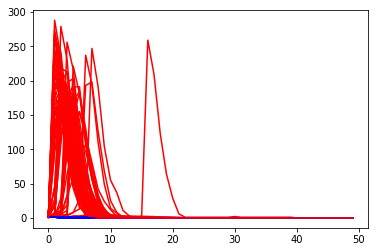

In [30]:
plot_run(10)

Works. But if we want to plot all the runs, from each level of the parameter sweep:

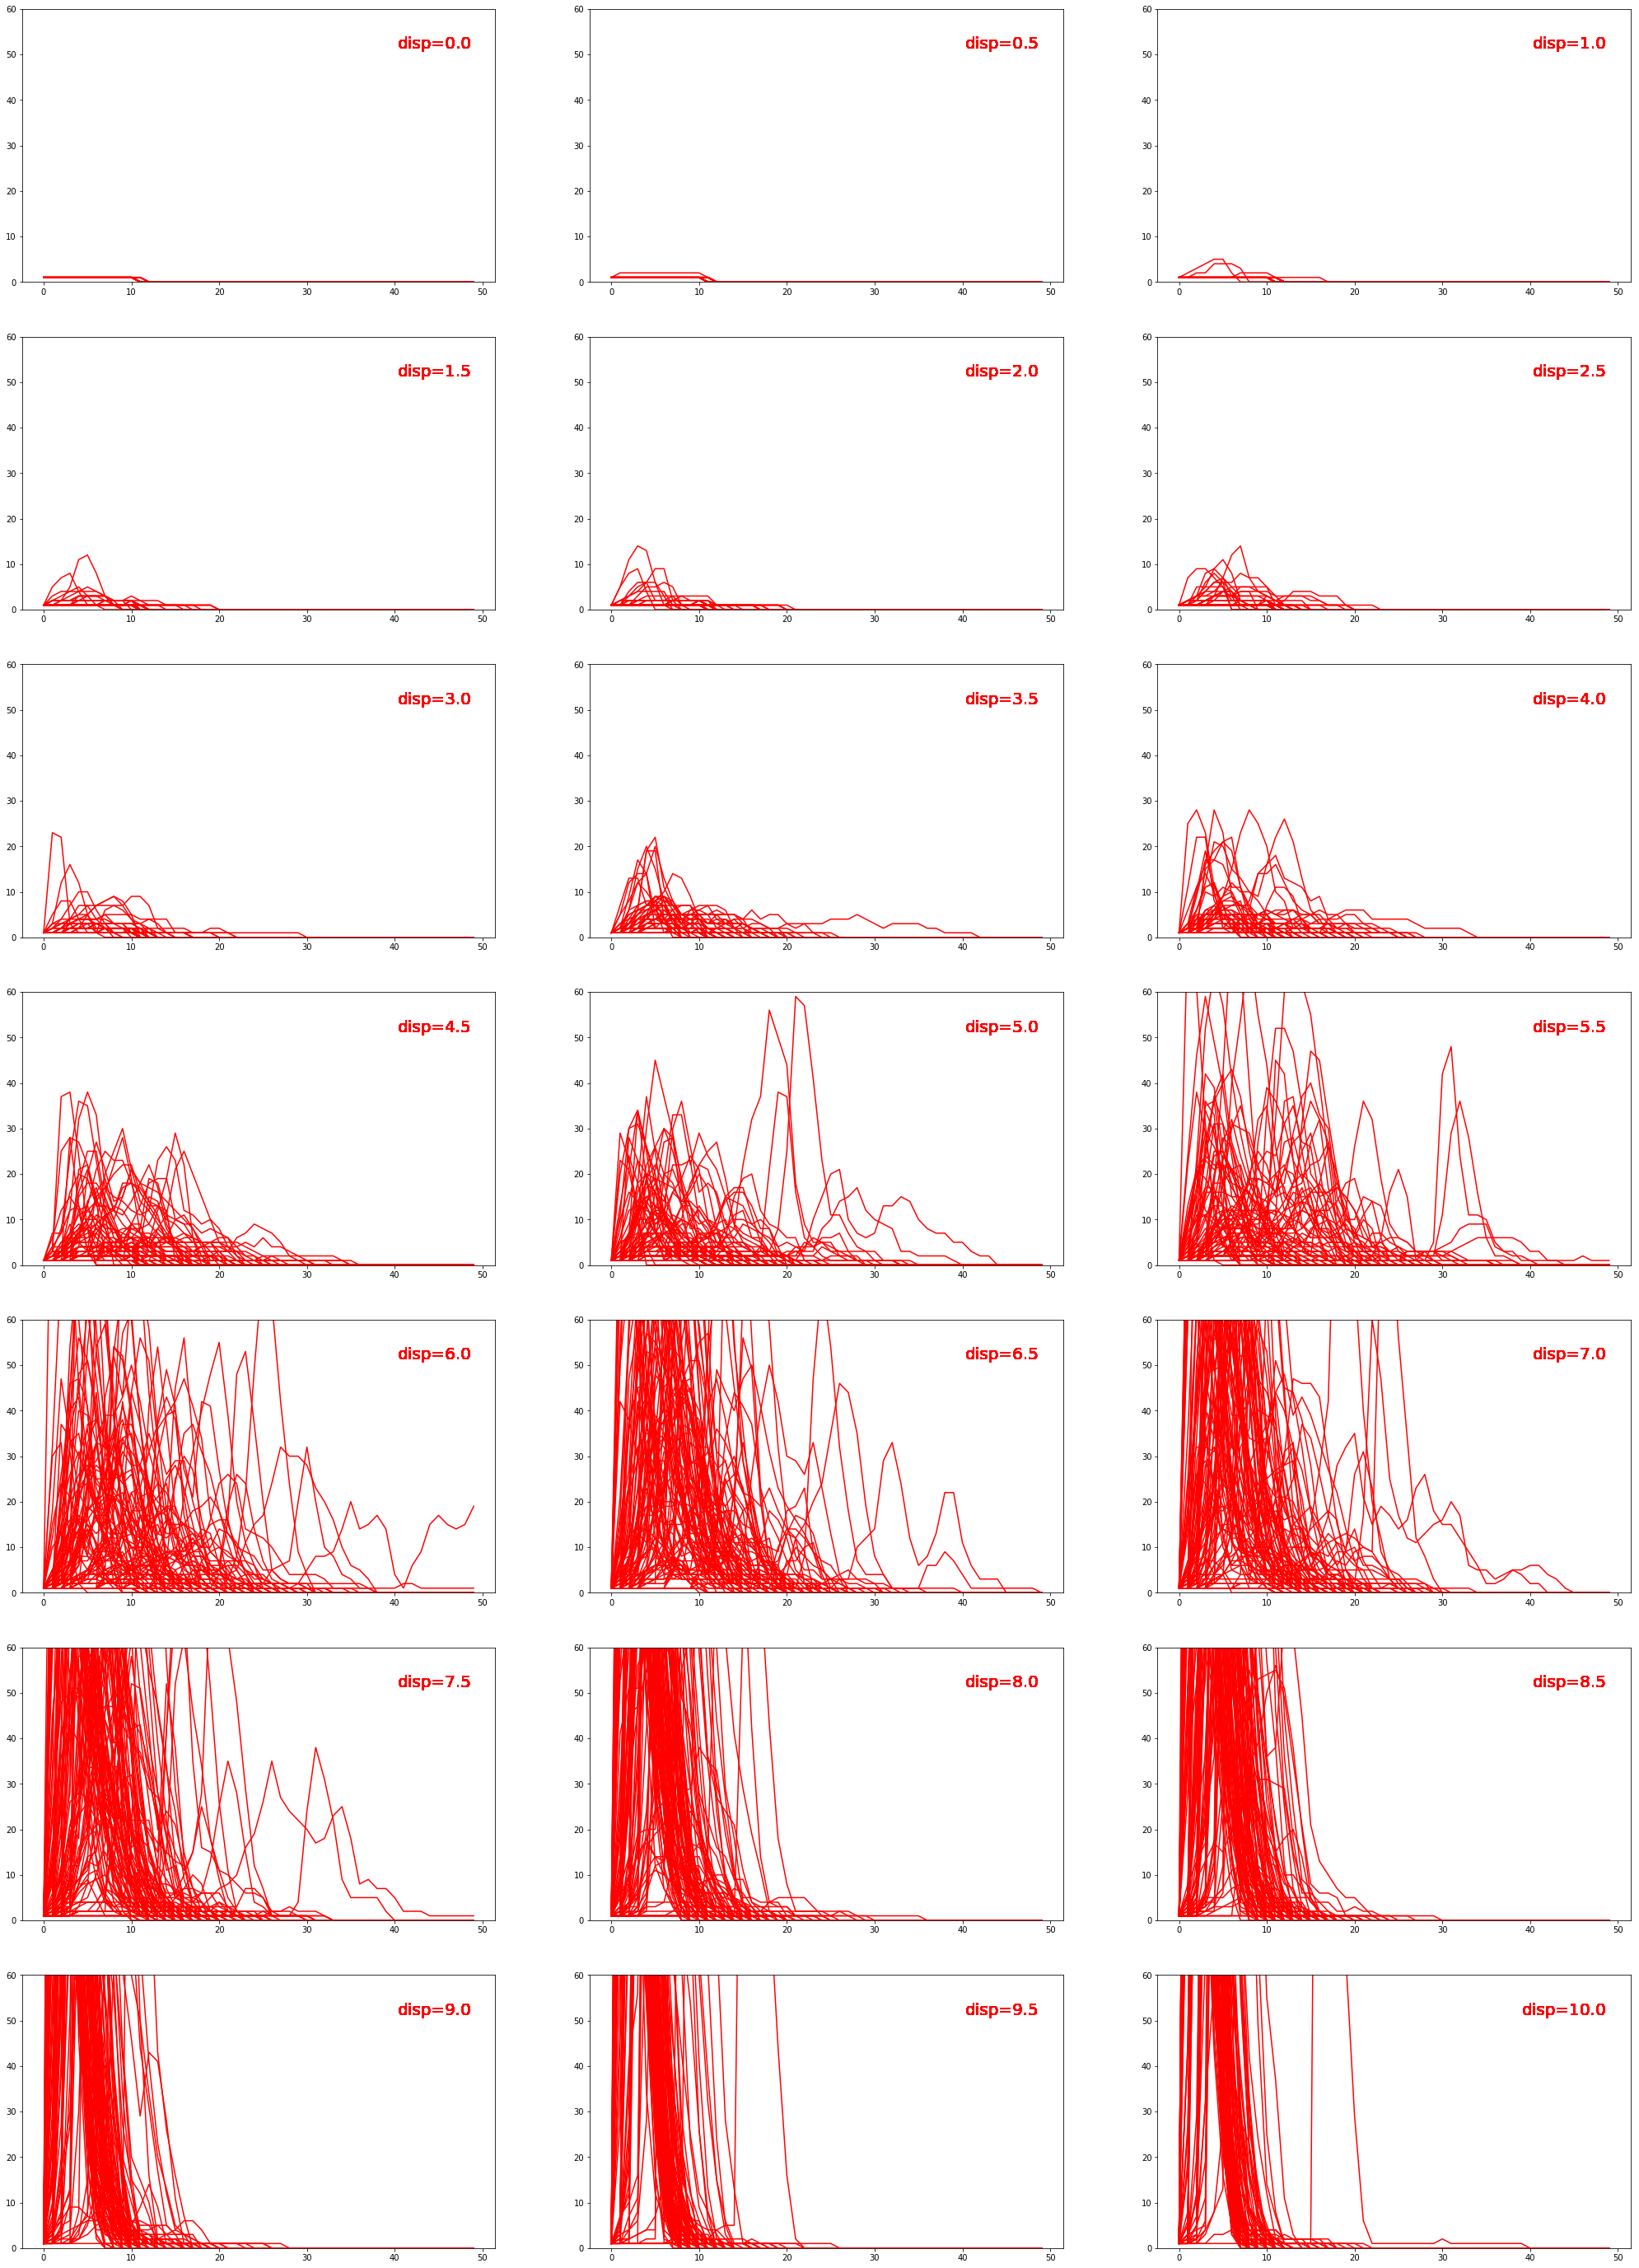

In [32]:
fig, axes = plt.subplots(7,3, figsize=(35, 50)) ## set figure, nrows and ncols, sizes
lvls = sorted(list(blue_runs.keys())) ## levels of the run, should be same as...
lvls2 = sorted(list(red_runs.keys())) ## don't need but might be useful check
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    for j in red_runs[lvls[i]]: ## plot all of our red fungi of a given level
        z.set_ylim([0, 60])
        z.plot([ h for h in range(50) ], j, c='r')
        z.text(.95, .9, 'disp=%s' % lvls[i],
                color='r',
                size='20',
                horizontalalignment='right',
                verticalalignment='top',
                transform=z.transAxes)
#    for j in blue_runs[lvls[i]]: ## plot our blue fungi next. 
#        z.plot([ h for h in range(50) ], j, c='b')
## blue commented out because not really useful here

So here we see that agressive dispersal is a mixed blessing. Fungi rapidly colonize and consume the initial supply of wood in an area. Surprisingly, in these simulations, highly dispersed fungi seem to persist about as long on the landscape as less-well dispersed fungi, or not as long. It seems that success at wood colonization can result in low abundance of wood, a kind of predator-prey cycle that result in starvation of the fungal population if replacement rates of wood are slow. This is of course assumes that a fungus doesn't persist in soil, etc, to recolonize wood as it becomes available, and assumes no immigration into the system.  

The lesson here? Some sort of lower-energy, lower-fitness-reward solution may be necessary to for most fungi in addition to spore dispersal a world of finite resources and dispersal, lest they become victims of their own success. 

[back to contents](#contents)

<a id='initialwood'></a>

## Changing initial abundances of wood

Can we create a situation where the single species of decomposer, spore-dispersed fungus can persist on the landscape? From the above trials, a spore dispersal coefficient of ~5 seems to represent the best compromise on the boom-bust-starve effect vs. stranding from underdispersion. We can hold this dispersal coefficient constant and vary the wood initial abundance and wood-deposition rates. So first, what will it look like if we vary initial abundances of wood?

In [35]:
decomp_runs = {}
for i in [ i for i in range(20,105,5) ]: ## levels of variable
    endo_list = []
    decomp_list = []
    for j in range(100): ## number of simulations per level of parameter
        losced = Forest(endophytism = False, ##settings for model
                        ws=i, ## parameter of interest
                        decompdisp=5, ## hold fungal dispersal here
                        endodisp=0, ## no blue fungi
                        )
        for j in range(50): losced.step() ## number of steps before ending the model
        ## data into lists
        endo_list.append(losced.datacollector.get_model_vars_dataframe().Endophytes)
        decomp_list.append(losced.datacollector.get_model_vars_dataframe().Decomposers)
   endo_runs[i] = endo_list
    decomp_runs[i] = decomp_list

#pickle.dump(endo_runs, open('blue_runs.p', 'wb'))
#pickle.dump(decomp_runs, open('red_runs.p', 'wb'))


Here are the results for a fungus with better dispersal abilities (decompdisp=6):

[back to contents](#contents)

## Effect of wood deposition rates

Here we assume an initial wood amount of 30 logs on the site, a medium-strong dispersing fungus (not endophyte-competent), and sweep over the rate of new wood deposition on the landscape:

In [ ]:
endo_runs = {}
decomp_runs = {}
for i in [ i for i in range(1,16) ]: ## levels of variable
    endo_list = []
    decomp_list = []
    for j in range(100): ## number of simulations per level of parameter
        losced = Forest(endophytism = False, ##settings for model
                        newwood=i, ## parameter of interest
                        ws=30,
                        decompdisp=6, ## hold fungal dispersal here
                        endodisp=0, ## no blue fungi
                        )
        for j in range(50): losced.step() ## number of steps before ending the model
        ## data into lists
        endo_list.append(losced.datacollector.get_model_vars_dataframe().Endophytes)
        decomp_list.append(losced.datacollector.get_model_vars_dataframe().Decomposers)
    endo_runs[i] = endo_list
    decomp_runs[i] = decomp_list
